# Plotting SNR vs. time of arrival

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib widget

import numpy as np
import json, logging
import argparse
import pandas as pd
from astropy.time import Time, TimeDelta
from astropy import units as u
import datetime
import pylab as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from frbpa.utils import get_phase, get_cycle, get_params
from scipy.optimize import curve_fit

In [2]:
data_json = '/home/ines/Documents/projects/R3/periodicity/r3all_data_searched.json'
plt_out = '/home/ines/Documents/projects/R3/periodicity/exposure_detections.pdf'
#plt_out = '/home/ines/Documents/PhD/meetings/20210303-Astrolunch_talk/figs/exposure_detections.png'
period = 16.35
ref_mjd = 58369.30
# period = 16.29
# ref_mjd = 58369.9
save = False
show = True 
max_freq = 2500
min_freq = 200

In [3]:
def sort_dict(dictionary, list):
    sorted_dict = {k: dictionary[k] for k in list if k in dictionary.keys()}
    return sorted_dict

def open_json(data_json):
    with open(data_json, 'r') as f:
        data = json.load(f)

    assert 'obs_duration' in data.keys()
    assert 'bursts' in data.keys()
    assert 'obs_startmjds' in data.keys()

    burst_dict = data['bursts']
    snr_dict = data['snr']
    obs_duration_dict = data['obs_duration']
    obs_startmjds_dict = data['obs_startmjds']
    fmin_dict = data['freq_min']
    fmax_dict = data['freq_max']

    assert len(obs_duration_dict.keys()) == len(obs_startmjds_dict.keys())
    assert len(obs_duration_dict.keys()) < 20
    assert len(burst_dict.keys()) < 10
    assert len(fmin_dict.keys()) ==  len(fmax_dict.keys())

    telescopes = list(obs_duration_dict.keys())

    new_obs_startmjds_dict = {}
    new_obs_duration_dict = {}
    fcen_dict = {}
    for k in obs_startmjds_dict.keys():
        start_times = obs_startmjds_dict[k]
        durations = obs_duration_dict[k]
        fmin = fmin_dict[k]
        fmax = fmax_dict[k]
        #new_start_times = []
        new_durations = []
        for i, t in enumerate(start_times):
            new_durations.append(durations[i]/(3600))
        new_obs_duration_dict[k] = new_durations
        fcen_dict[k] = (fmax + fmin)/2
    obs_duration_dict = new_obs_duration_dict

    # Sorting dictionaries by central frequency
    fcen_dict = {k: v for k, v in sorted(fcen_dict.items(),
            key=lambda item: item[1])}
    burst_dict = sort_dict(burst_dict, fcen_dict.keys())
    snr_dict = sort_dict(snr_dict, fcen_dict.keys())
    obs_duration_dict = sort_dict(obs_duration_dict, fcen_dict.keys())
    obs_startmjds_dict = sort_dict(obs_startmjds_dict, fcen_dict.keys())
    fmin_dict = sort_dict(fmin_dict, fcen_dict.keys())
    fmax_dict = sort_dict(fmax_dict, fcen_dict.keys())

    return burst_dict, snr_dict, obs_duration_dict, obs_startmjds_dict, fmin_dict, fmax_dict, fcen_dict

In [4]:
burst_dict, snr_dict, obs_duration_dict, obs_startmjds_dict, fmin_dict, fmax_dict, fcen_dict = open_json(data_json)

In [5]:
# Defining duty cycle
frequency_hours = '%fH' % (24 * period)
t = Time(ref_mjd, format='mjd')
t0 = t+((period/2)*u.day)
tf = Time('2020-12-15T00:00:00', format='isot') #datetime.datetime.now()

t0_low = t+((period/2)*u.day) - (2.6 * u.day)
t0_high = t+((period/2)*u.day) + (2.6 * u.day)

df_period = [t0]
df_duty_low = [t0_low]
df_duty_high = [t0_high]
t_activity, t_low, t_high = t0, t0_low, t0_high
while t_activity <= tf:
    t_activity += period
    t_low += period
    t_high += period
    df_period.append(t_activity)
    df_duty_low.append(t_low)
    df_duty_high.append(t_high)

n_periods = len(df_period)
print(n_periods)

52


In [6]:
# Cycles to show
n_min = 34
n_max = 50.8
# n_min = 35.4
# n_max = 35.7
t_min = ref_mjd + period * n_min
t_max = ref_mjd + period * n_max

# Instruments to show
telescopes = ['LOFAR', 'uGMRT400', 'CHIME/FRB', 'uGMRT650', 'Apertif', 'VLA']

In [7]:
# DEFINING COLORS
cm = plt.cm.get_cmap('Spectral_r')
#burst_hist_colors = []
obs_hist_colors = {}
fcen_dict['uGMRT650'] = 1000
for i,k in enumerate(obs_duration_dict.keys()):
    freq = np.log10(fcen_dict[k])
    c = (np.log10(max_freq)-freq)/(np.log10(max_freq)-np.log10(min_freq))
    color = cm(c)
#     if k in burst_dict.keys():
#         burst_hist_colors.append(color)
    obs_hist_colors[k] = color
fcen_dict['GMRT650'] = 650
    
# Defining plot parameters
params = {'backend': 'pdf',
    'axes.labelsize': 14,
    'lines.markersize': 7,
    'font.size': 14,
    'font.family': 'sans-serif',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.top': True,
    'ytick.right': True,
    'xtick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.major.size': 6,
    'ytick.minor.size': 3,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'lines.markeredgewidth': 0.5,
    'axes.linewidth': 1.2,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'savefig.dpi': 200,
    'path.simplify': True,
    'figure.figsize': [13,8]}

### Simple plot

LOFAR 9 9
uGMRT 4 4
CHIME/FRB 57 57
uGMRT 15 15
Apertif 54 54
VLA 1 1
Plot saved: /home/ines/Documents/projects/R3/periodicity/exposure_detections.pdf


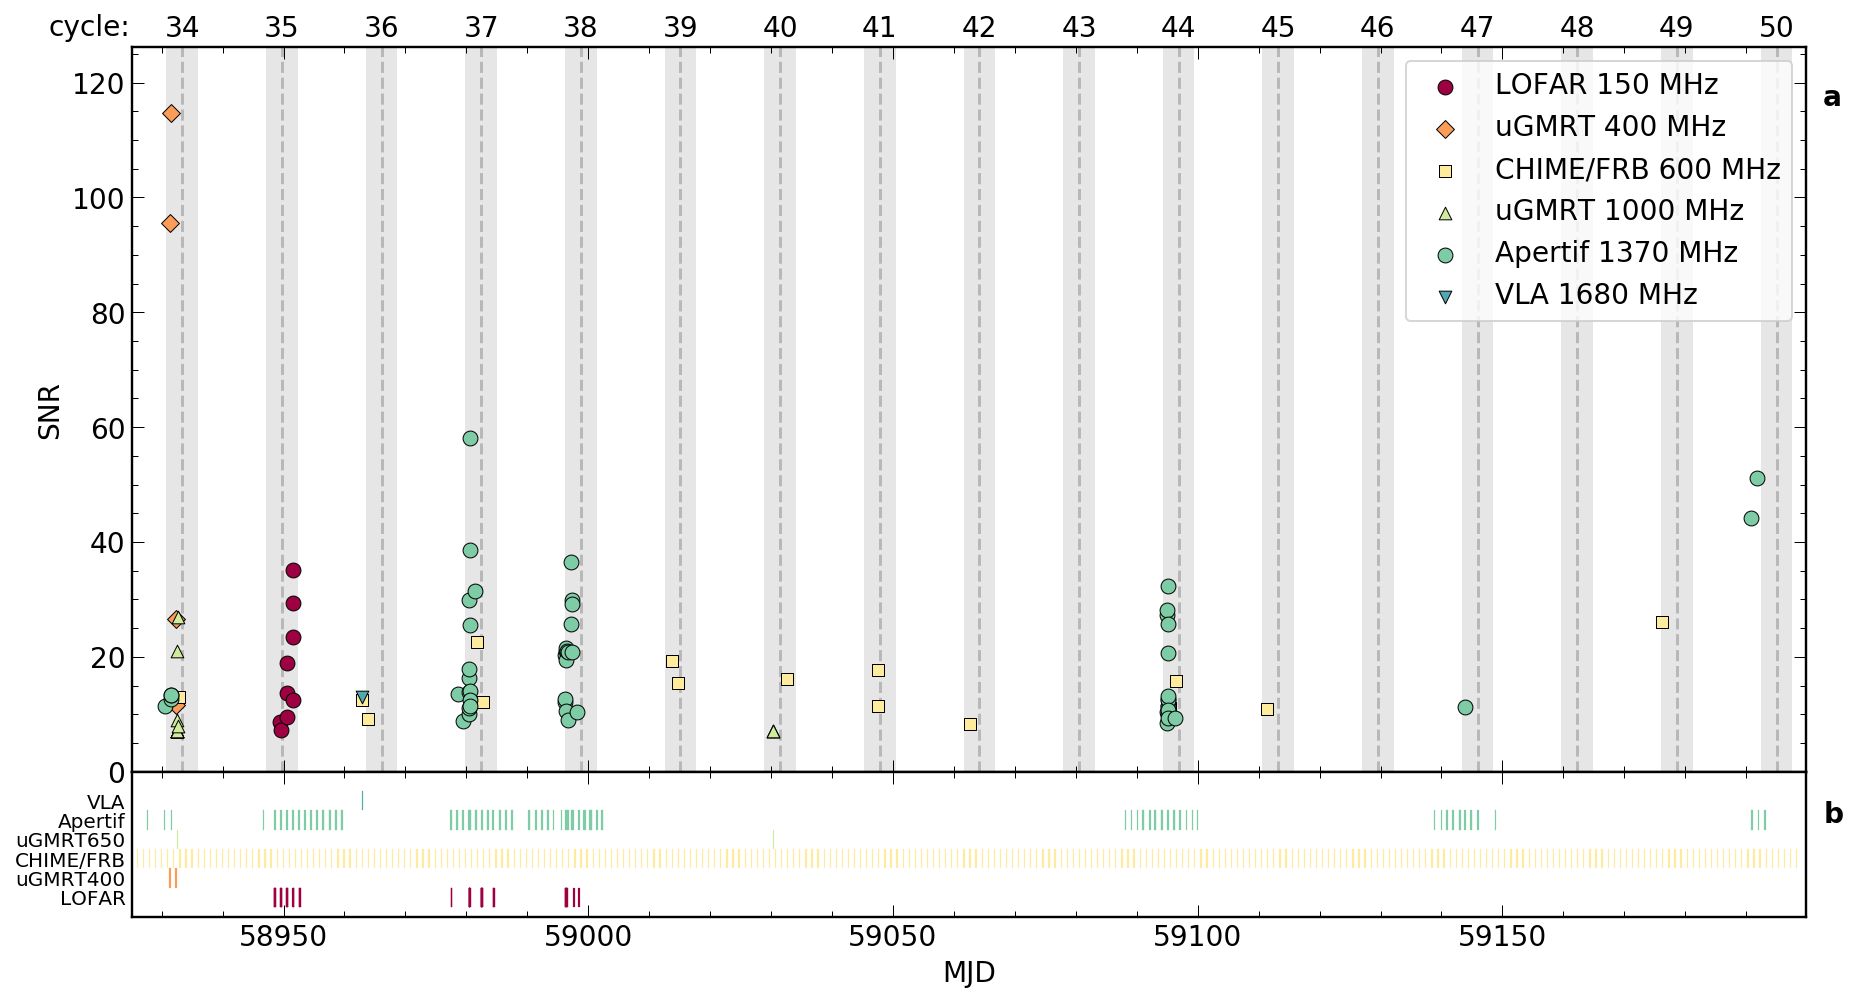

In [11]:
# PLOTTING
fig = plt.figure(figsize=(15,8))
plt.rcParams.update(params)
gs = gridspec.GridSpec(2,1, hspace=0., height_ratios=[5,1])
markers = ["D", "s", "^", "v"]

ax1 = fig.add_subplot(gs[0, 0]) #ax[0]

j = 0
for i,k in enumerate(telescopes):
    inst = ''.join([i for i in k if not i.isdigit()])
    print(inst, len(burst_dict[k]), len(snr_dict[k]))
    if k in ['Apertif', 'LOFAR']:
        s = 55
        m = 'o'
    else:
        s = 40
        m = markers[j]
        j += 1
    ax1.scatter(burst_dict[k], snr_dict[k],
            color=obs_hist_colors[k], label="{} {} MHz".format(inst, int(fcen_dict[k])), 
            marker=m, s=s, zorder=10, edgecolors='k', linewidth=0.5)

max_snr = max([m for k in snr_dict.keys()
        for m in snr_dict[k]])*1.1
ax1.set_ylim(0, max_snr)
ax1.set_ylabel('SNR')


ax2 = fig.add_subplot(gs[1, 0], sharex=ax1) #ax[1]
for i, k in enumerate(telescopes):
    obs_patches = []
    inst = ''.join([i for i in k if not i.isdigit()])
    for j,start in enumerate(obs_startmjds_dict[k]):
        obs = Rectangle((start,i), max(0.2,obs_duration_dict[k][j]/24), 1)
        #obs = Rectangle((start,i), obs_duration_dict[k][j]/24, 1)
        obs_patches.append(obs)
    pc = PatchCollection(obs_patches, facecolor=obs_hist_colors[k],
            alpha=1, edgecolor=obs_hist_colors[k], label=inst, linewidth=0.1)
    ax2.add_collection(pc)

max_mjdstart = max([m for k in obs_startmjds_dict.keys()
        for m in obs_startmjds_dict[k]])
min_mjdstart = min([m for k in obs_startmjds_dict.keys()
        for m in obs_startmjds_dict[k]])
max_f = max(fmax_dict.values())+1e3
min_f = min(fmin_dict.values())-10
ax2.set_xlim(t_min, t_max)
ax2.set_ylim(-0.5, len(telescopes)+1)
ax2.set_xlabel('MJD')
#ax2.set_yticks([])
ax2.set_yticks([i+0.5 for i in range(len(telescopes))])
ax2.set_yticklabels(telescopes, fontsize=10)
ax2.tick_params(axis='y', which='both', length=0)

# duty cycle
for low, high in zip(df_duty_low, df_duty_high):
    ax1.axvspan(low.value, high.value, facecolor='#0f0f0f', alpha=0.1)
for ii,peak in enumerate(df_period):
    ax1.vlines(peak.value, 0, max_snr, linestyles='dashed', alpha=0.2)
    if peak.value >= t_min and peak.value <= t_max:
        ax1.text(peak.value, 128, ii, horizontalalignment='center')

ax1.legend(loc=1)
ax1.text(-0.05, 1.015, "cycle:", transform=ax1.transAxes)
ax1.text(1.01, 0.95, "a", verticalalignment='top', transform=ax1.transAxes, weight='bold')
ax2.text(1.01, 0.8, "b", verticalalignment='top', transform=ax2.transAxes, weight='bold')
plt.setp(ax1.get_xticklabels(), visible=False)
for ax in (ax1,ax2):
    ax.tick_params(axis='x', which='both', direction='in', bottom=True,
            top=True)
    ax.tick_params(axis='y', which='both', direction='in', left=True,
            right=True)
    
plt.savefig(plt_out, pad_inches=0, bbox_inches='tight', dpi=200)
print('Plot saved:', plt_out)

In [25]:
for ii,burst in enumerate(burst_dict['LOFAR']):
    print("{:.5f}".format(get_phase(burst, period, ref_mjd=ref_mjd)))

0.48582
0.49496
0.54936
0.55010
0.55268
0.61128
0.61228
0.61392
0.61432


# Fluence dependence with phase

In [10]:
def sort_dict(dictionary, list):
    sorted_dict = {k: dictionary[k] for k in list if k in dictionary.keys()}
    return sorted_dict

In [11]:
fluence_fn = '/home/ines/Documents/projects/R3/arts/fluxcal/fluence_int.txt'
#fluence_fn = '/home/ines/Documents/projects/R3/arts/fluxcal/fluence_int.txt'
fl = np.genfromtxt(fluence_fn, names=True)
arts_fluence, arts_ferr = [], []
for i in range(len(fl)):
    #if fl['snr'][i] >= 15:
        arts_fluence.append(fl['fint_Jyms'][i])
        arts_ferr.append(fl['fint_err'][i])
#     else:
#         arts_fluence.append(fl['fluence_Jyms'][i])
#         arts_ferr.append(fl['fluence_err'][i])
        
# print('Flux')
# for elem in fl['flux_Jy']:
#     print(elem) 
# print('Error')
# for elem in fl['flux_err']:
#     print(elem )

# Sorting by fluence
arts_width = [x for _,x in sorted(zip(arts_fluence,fl['width_ms']))]
arts_snr = [x for _,x in sorted(zip(arts_fluence,fl['snr']))]
arts_mjd = [x for _,x in sorted(zip(arts_fluence,fl['MJD']))]
arts_ferr = [x for _,x in sorted(zip(arts_fluence,arts_ferr))]
arts_phase = get_phase(fl['MJD'], period, ref_mjd=ref_mjd)
arts_phase = [x for _,x in sorted(zip(arts_fluence,arts_phase))]
arts_fluence.sort()
print(arts_fluence)

[-0.2, 0.53, 0.68, 0.82, 0.93, 0.99, 1.17, 1.49, 1.49, 1.53, 1.54, 1.59, 1.6, 1.68, 1.73, 1.74, 1.86, 1.87, 1.89, 1.94, 2.17, 2.18, 2.27, 2.3, 2.42, 2.47, 2.54, 2.55, 2.63, 2.95, 3.11, 3.44, 3.57, 3.75, 3.89, 4.87, 5.39, 5.51, 5.61, 5.88, 6.06, 6.21, 6.4, 6.61, 6.66, 7.0, 7.44, 7.61, 9.6, 10.99, 17.62]


(0, 20.262999999999998)

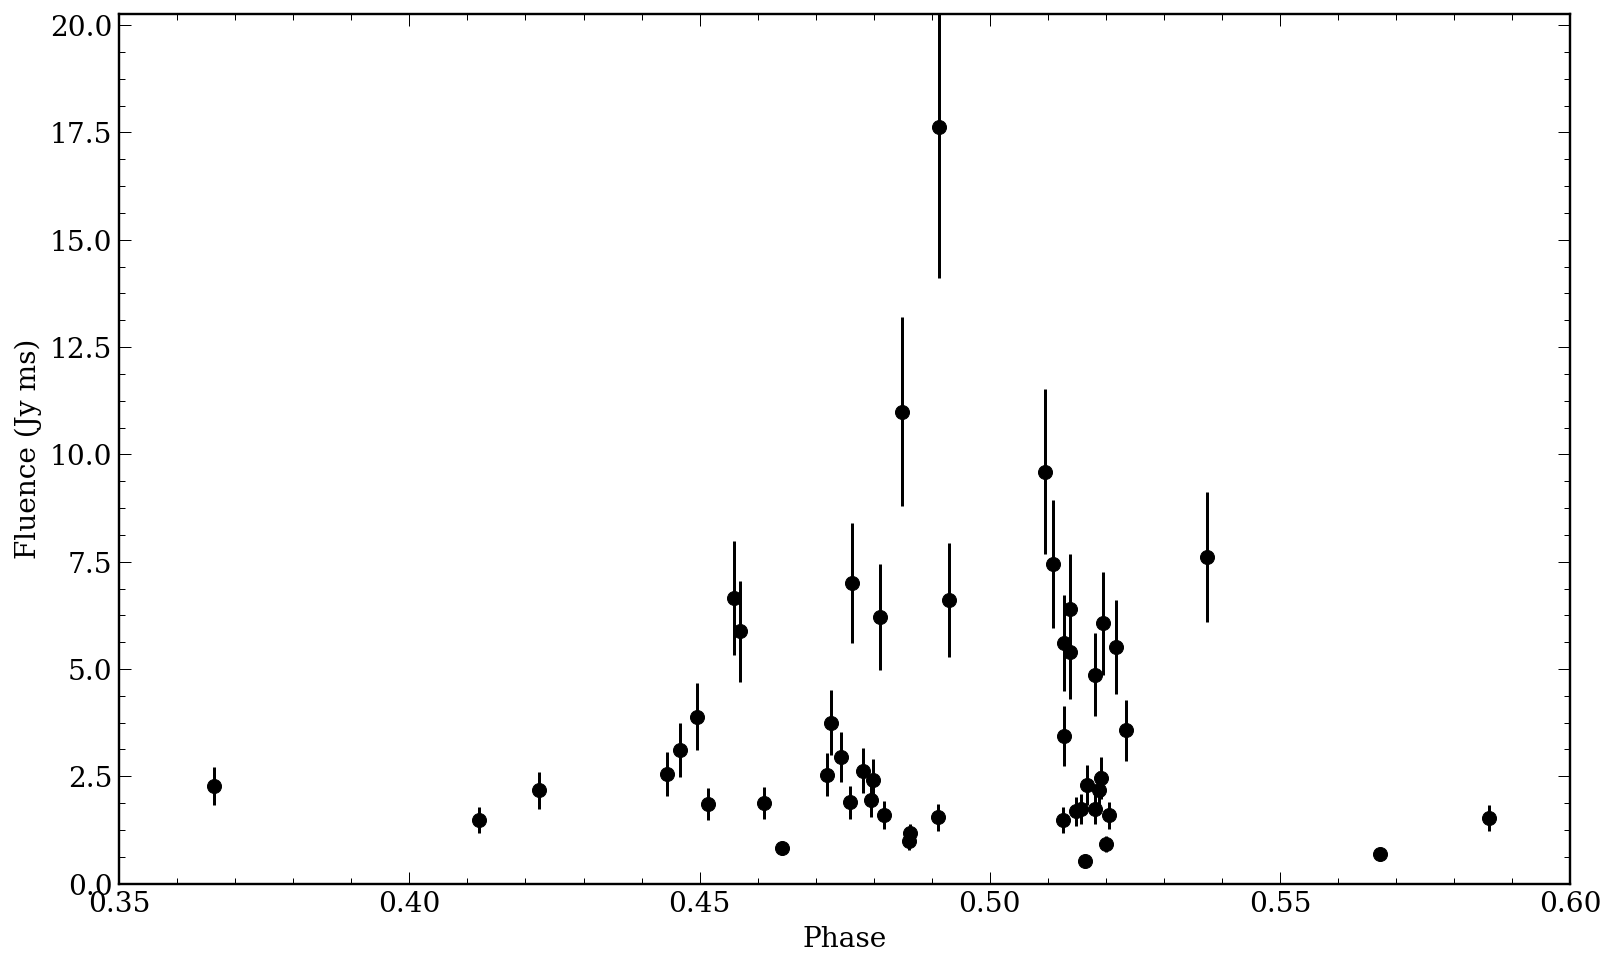

In [12]:
plt.errorbar(arts_phase, arts_fluence, yerr=arts_ferr, fmt='o', color='k', zorder=10)
plt.ylabel('Fluence (Jy ms)')
plt.xlabel('Phase')
plt.xlim(0.35,0.6)
plt.ylim(0,1.15*max(arts_fluence))

Text(0.5, 0, 'ID')

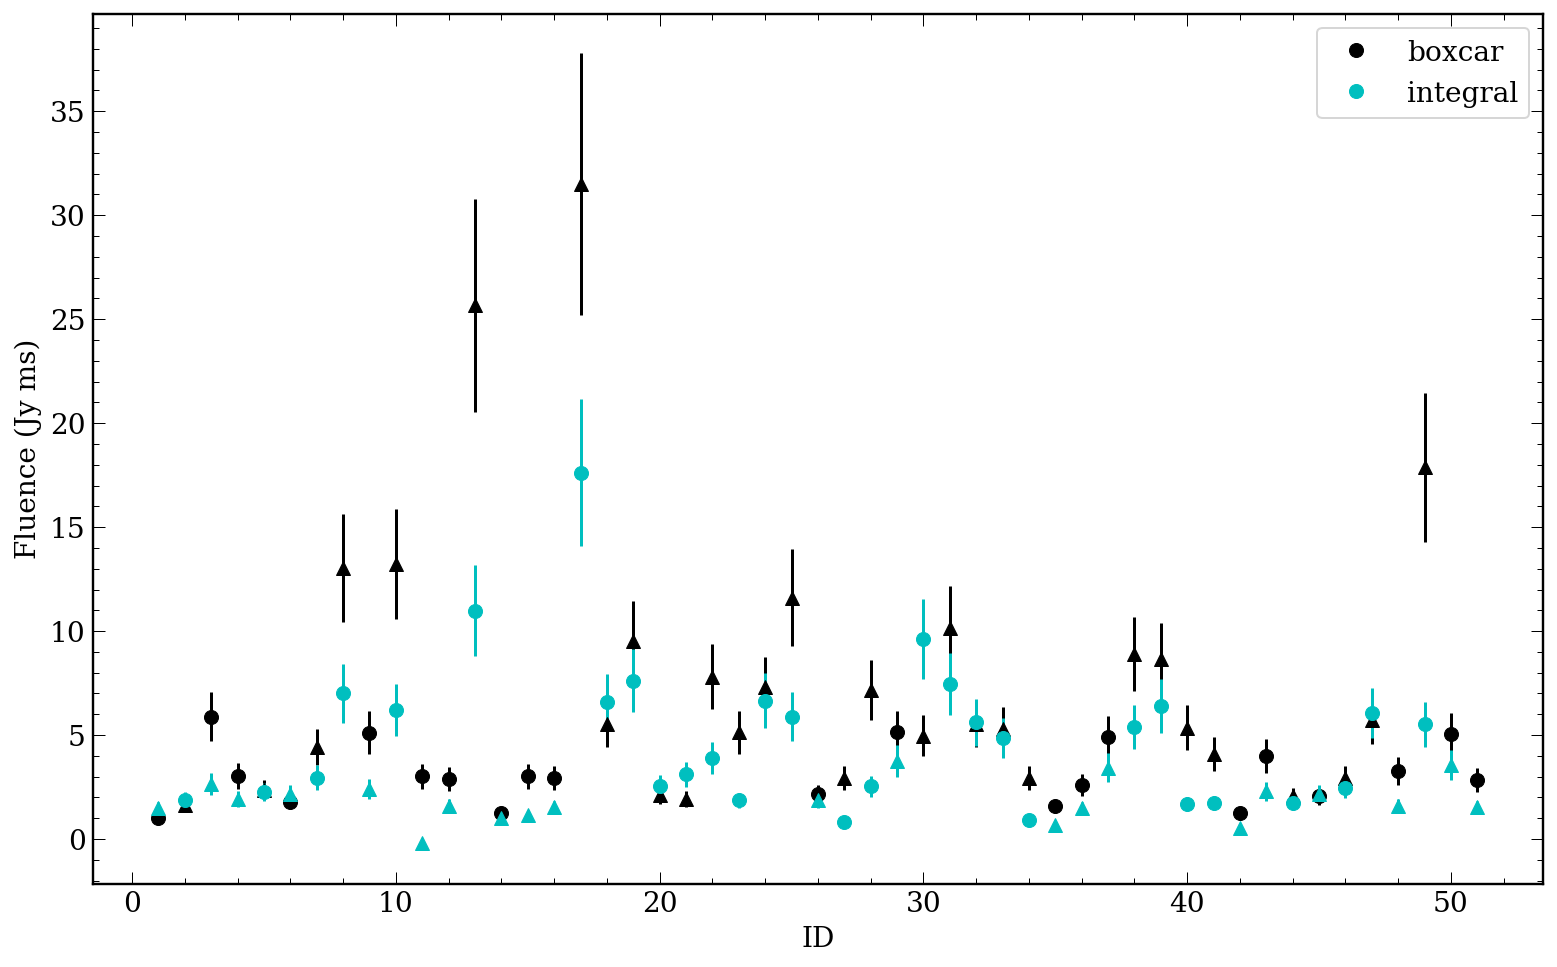

In [13]:
arts_fluence = []
for i in range(len(arts_mjd)):
    j = i+1
#     if fl['snr'][i] >= 15:
#         plt.errorbar(arts_phase[i], fl['fluence_Jyms'][i], yerr=fl['fluence_err'][i], marker='^',
#                      color='k', zorder=10)
#         plt.errorbar(arts_phase[i], fl['fint_Jyms'][i], yerr=fl['fint_err'][i], marker='o', color='c', zorder=10)
#     else:
#         plt.errorbar(arts_phase[i], fl['fluence_Jyms'][i], yerr=fl['fluence_err'][i], 
#                      marker='o', color='k', zorder=10)
#         plt.errorbar(arts_phase[i], fl['fint_Jyms'][i], yerr=fl['fint_err'][i], marker='^', 
#                      color='c', zorder=10)
    if fl['snr'][i] >= 15:
        plt.errorbar(j, fl['fluence_Jyms'][i], yerr=fl['fluence_err'][i], marker='^',
                     color='k', zorder=10)
        plt.errorbar(j, fl['fint_Jyms'][i], yerr=fl['fint_err'][i], marker='o', color='c', zorder=10)
        arts_fluence.append(fl['fint_Jyms'][i])
    else:
        plt.errorbar(j, fl['fluence_Jyms'][i], yerr=fl['fluence_err'][i], 
                     marker='o', color='k', zorder=10)
        plt.errorbar(j, fl['fint_Jyms'][i], yerr=fl['fint_err'][i], marker='^', 
                     color='c', zorder=10)
        arts_fluence.append(fl['fluence_Jyms'][i])


lines = [plt.plot([], 'o', color='k')[0],
        plt.plot([], 'o', color='c')[0]]
labels=['boxcar', 'integral']

plt.legend(lines, labels)


plt.ylabel('Fluence (Jy ms)')
plt.xlabel('ID')
#plt.xlim(0.3,0.45)

# Cumulative distribution function

$$E = 4\pi d^2_L f_b F \Delta\nu$$

Luminosity distance $d_L = 149.0\pm0.9$ Mpc

Bandwidth $\Delta\nu = 300$ MHz

Beaming fraction $f_b = 1$

In [14]:
csvname = '/home/ines/Documents/projects/R3/arts/arts_r3_properties.csv'
burst_data = np.genfromtxt(csvname, delimiter=',', names=True)

arts_fluence = burst_data['fluence_Jyms']
#arts_width = [x for _,x in sorted(zip(arts_fluence,fl['width_ms']))]
arts_snr = [x for _,x in sorted(zip(arts_fluence,burst_data['snr']))]
arts_mjd = [x for _,x in sorted(zip(arts_fluence,burst_data['bary_mjd']))]
arts_ferr = [x for _,x in sorted(zip(arts_fluence,burst_data['fluence_err']))]
arts_phase = get_phase(burst_data['bary_mjd'], period, ref_mjd=ref_mjd)
arts_phase = [x for _,x in sorted(zip(arts_fluence,arts_phase))]
arts_fluence.sort()

## Fluence and energy

In [15]:
def fluence_to_energy(fluence, d_L=149, BW=300, f_b=1):
    """
    Converting fluence (Jy ms) into energy (erg)
    
    Parameters
    ----------
        fluence: float or np.array in Jy ms
        d_L: luminosity distance in Mpc
        BW: bandwidth in MHz
        f_b: beaming fraction
        
    Returns
    -------
        energy in ergs
    """
    
    fluence = fluence * u.Jy * u.ms
    d_L = d_L * u.Mpc
    BW = BW * u.MHz
    
    energy = 4*pi * d_L**2 * f_b * fluence * BW
    return energy.to('erg')

In [16]:
d_L = 149
BW = 300

In [17]:
arts_obs_time = np.sum(obs_duration_dict['Apertif'])
cumulative_rate = np.array([(len(arts_fluence)-i)/arts_obs_time for i in range(len(arts_fluence))])
cumulative_n = np.array([len(arts_fluence)-i for i in range(len(arts_fluence))])
cumulative_snr = np.array([len(arts_snr)-i for i in range(len(arts_fluence))])

In [18]:
arts_energy = fluence_to_energy(arts_fluence)
print(arts_energy)

[4.22357894e+36 5.41893147e+36 6.53459383e+36 7.41118569e+36
 7.88932670e+36 9.32374973e+36 1.18738351e+37 1.18738351e+37
 1.21925958e+37 1.22722860e+37 1.26707368e+37 1.27504270e+37
 1.33879483e+37 1.37863992e+37 1.38660893e+37 1.43442304e+37
 1.48223714e+37 1.49020615e+37 1.50614419e+37 1.54598927e+37
 1.72927666e+37 1.73724568e+37 1.80896683e+37 1.83287388e+37
 1.92850208e+37 1.96834717e+37 2.02413028e+37 2.03209930e+37
 2.09585144e+37 2.35085998e+37 2.39867408e+37 2.47836425e+37
 2.74134180e+37 2.84493902e+37 2.98838132e+37 3.09994756e+37
 3.88091121e+37 4.29530009e+37 4.39092829e+37 4.47061846e+37
 4.68578192e+37 4.82922422e+37 4.94875947e+37 5.10017079e+37
 5.26752015e+37 5.30736523e+37 5.57831181e+37 5.92894855e+37
 6.06442184e+37 7.65025619e+37 8.75794954e+37 1.40414077e+38] erg


### Pulsar CMD for comparison

In [19]:
fluence_psr_fn = '/home/ines/Documents/projects/R3/arts/fluxcal/fluence_int_B1933.txt'
flpsr = np.genfromtxt(fluence_psr_fn, names=True)
psr_fluence = flpsr['fint'][:52]
psr_fluence.sort()

## Fitting CFD to powerlaw

$$N(>F)\propto F^{\alpha+1}$$

In [20]:
def func_powerlaw(x, alpha, c):
    return c * x**(alpha+1)

In [21]:
#popt_all, pcov_all = curve_fit(func_powerlaw, arts_fluence, cumulative_n)
# i_high = np.where(arts_fluence>10)[0]
# popt_high, pcov_high = curve_fit(func_powerlaw, arts_fluence[i_high], cumulative_n[i_high], p0=(-2.5,-10,35))
# i_low = np.where(arts_fluence<10)
# popt_low, pcov_low = curve_fit(func_powerlaw, arts_fluence[i_low], cumulative_n[i_low], p0=(-1.5,-10,35))

x = np.logspace(0,2,num=100)
#print('All', popt_all)
# print('High fluence', popt_high)
# print('Low fluence', popt_low)

## Plotting CDF

0.53


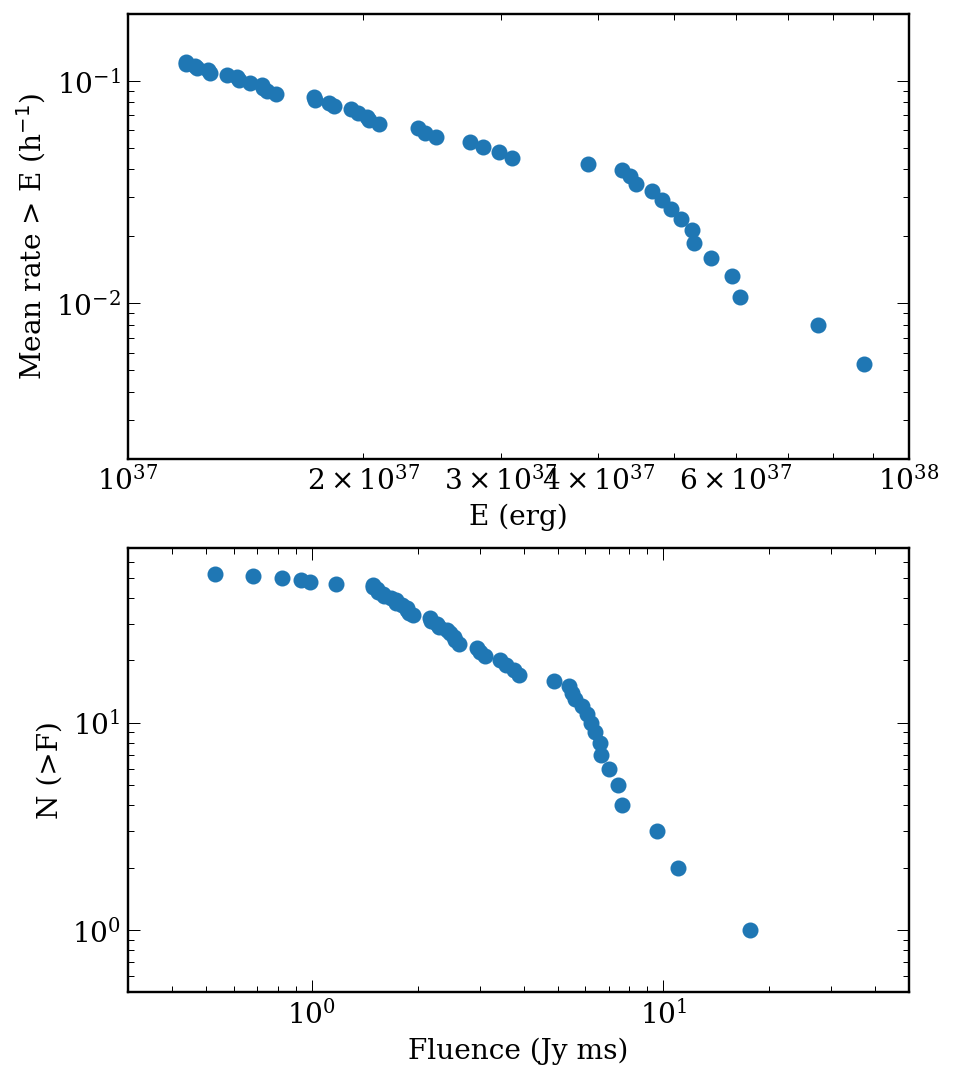

In [22]:
fig = plt.figure(figsize=(7,9))
gs = gridspec.GridSpec(2,1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(arts_energy, cumulative_rate)
ax1.set_xlabel('E (erg)')
ax1.set_ylabel('Mean rate > E (h$^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e37,1e38)
ax1.set_ylim(2e-3,0.2)

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(arts_fluence, cumulative_n, zorder=10)
#ax2.plot(x, func_powerlaw(x, *popt_all), color='C1')
# ax2.plot(x, func_powerlaw(x, *popt_high), color='C2')
# ax2.plot(x, func_powerlaw(x, *popt_low), color='C3')
# ax2.text(0.95, 0.95, r"$N(>F)\propto F^{}$".format(popt[0]), verticalalignment='top', 
#         horizontalalignment='right', transform=ax1.transAxes, fontsize=14)
ax2.set_xlabel('Fluence (Jy ms)')
ax2.set_ylabel('N (>F)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(3e-1,50)
ax2.set_ylim(5e-1,70)
print(min(arts_fluence))

In [23]:
print(min(arts_phase), max(arts_phase))
print(0.485-0.13, 0.485-0.0275, 0.485-0.0075, 0.485+0.0075, 0.485-0.0275, 0.485+0.13)
print(0.36, 0.36+0.08, 0.36+0.11, 0.36+0.13, 0.36+0.16, 0.6)

0.36621323327207217 0.5861515475751797
0.355 0.45749999999999996 0.4775 0.4925 0.45749999999999996 0.615
0.36 0.44 0.47 0.49 0.52 0.6


### Fluence CDF

[ 0.53  0.68  0.82  0.93  0.99  1.17  1.49  1.49  1.53  1.54  1.59  1.6
  1.68  1.73  1.74  1.8   1.86  1.87  1.89  1.94  2.17  2.18  2.27  2.3
  2.42  2.47  2.54  2.55  2.63  2.95  3.01  3.11  3.44  3.57  3.75  3.89
  4.87  5.39  5.51  5.61  5.88  6.06  6.21  6.4   6.61  6.66  7.    7.44
  7.61  9.6  10.99 17.62]
[1.49, 1.49, 1.53, 1.54, 1.59, 1.6, 1.68, 1.73, 1.74, 1.8, 1.86, 1.87, 1.89, 1.94, 2.17, 2.18, 2.27, 2.3, 2.42, 2.47, 2.54, 2.55, 2.63, 2.95, 3.01, 3.11, 3.44, 3.57, 3.75, 3.89, 4.87] [46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16]
[  -4.08204644 2658.90651522]
[-1.98025374 65.77805084]
[-1.12974414 48.26006106]


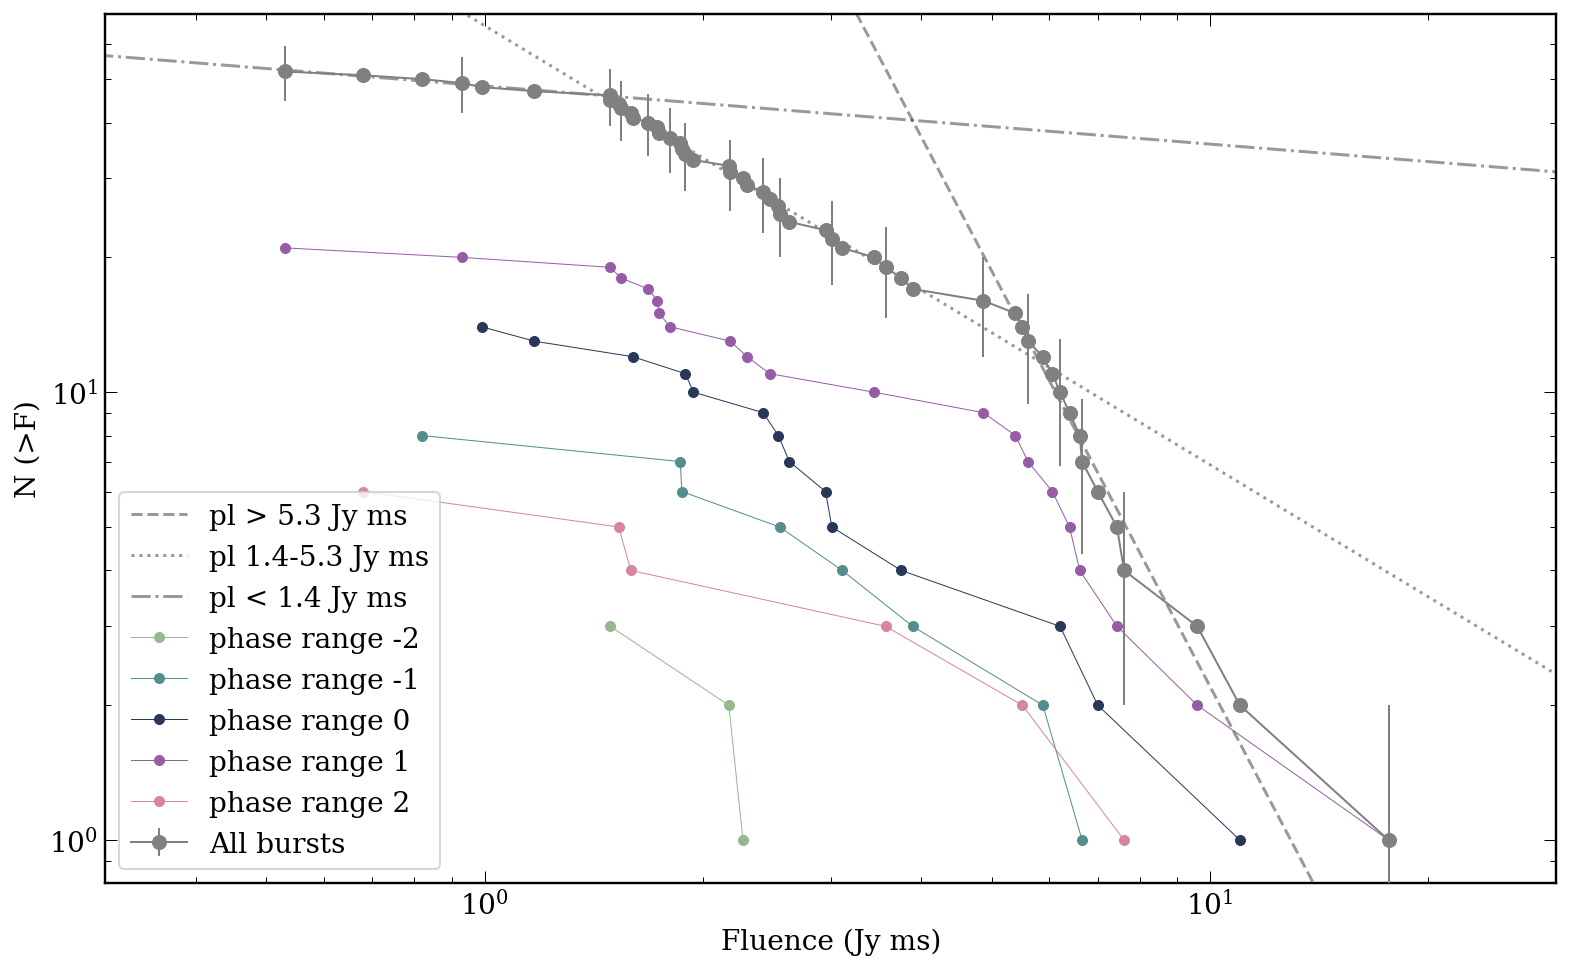

In [24]:
cm = plt.cm.get_cmap('twilight')
#cm = plt.cm.get_cmap('RdYlGn')
fig = plt.figure()
gs = gridspec.GridSpec(1,1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(arts_fluence, cumulative_n, yerr=np.sqrt(cumulative_n), errorevery=3, 
             zorder=10, linestyle='-', lw=1, marker='o', color='gray', label="All bursts")
# ax1.plot(arts_fluence, cumulative_n,
#              zorder=10, linestyle='-', lw=1, marker='o', color='k', label="All bursts")
ax1.set_xlabel('Fluence (Jy ms)')
ax1.set_ylabel('N (>F)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(3e-1,30)
ax1.set_ylim(8e-1,70)

fl_hi, fl_md, fl_lo = [], [], []
cm_hi, cm_md, cm_lo = [], [], []

print(arts_fluence)

for j,f in enumerate(arts_fluence):
    if f < 1.4:
        fl_lo.append(f)
        cm_lo.append(cumulative_n[j])
    elif f > 5.3:
        fl_hi.append(f)
        cm_hi.append(cumulative_n[j])
    else:
        fl_md.append(f)
        cm_md.append(cumulative_n[j])

print(fl_md, cm_md)
        
# Fitting
p0=[-2.3, 100]
coeff_hi, var_hi = curve_fit(func_powerlaw, fl_hi, cm_hi, p0=p0, sigma=np.sqrt(cm_hi))
print(coeff_hi)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_hi), 
         color='k', alpha=0.4, linestyle='--', label='pl > 5.3 Jy ms')

coeff_md, var_md = curve_fit(func_powerlaw, fl_md, cm_md, p0=p0, sigma=np.sqrt(cm_md))
print(coeff_md)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_md), 
         color='k', alpha=0.4, linestyle='dotted', label='pl 1.4-5.3 Jy ms')

coeff_lo, var_lo = curve_fit(func_powerlaw, fl_lo, cm_lo, p0=p0, sigma=np.sqrt(cm_lo))
print(coeff_lo)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_lo), 
         color='k', alpha=0.4, linestyle='-.', label='pl < 1.4 Jy ms')

phase_range = [0.36, 0.44, 0.47, 0.49, 0.52, 0.6]
color_test=['#95b88c', '#538d8c', '#2a3857', '#965da6', '#d685a4', 'C6', 'C7']
for i,p in enumerate(phase_range[:-1]):
    #c = cm((i+1)/len(phase_range))
    c = color_test[i]
    flist = []
    for j,f in enumerate(arts_fluence):
        if arts_phase[j] > p and arts_phase[j] < phase_range[i+1]:
            flist.append(f)
    #print(flist)
    ax1.plot(flist, [len(flist)-i for i in range(len(flist))], linestyle='-', marker='o', color=c,
            label="phase range "+str(i-2), markersize=5, linewidth=0.5)
ax1.legend()

# ax1.axvline(1.4, ymin=0, ymax=1e3, zorder=0, color='k', ls=(0, (5, 1)), alpha=0.3)
# ax1.axvline(5.3, ymin=0, ymax=1e3, zorder=0, color='k', ls=(0, (5, 1)), alpha=0.3)


plt_fl = '/home/ines/Documents/projects/R3/arts/fluxcal/cdf_fluence.pdf'
plt.savefig(plt_fl, pad_inches=0, bbox_inches='tight', dpi=200)

[ 0.53  0.68  0.82  0.93  0.99  1.17  1.49  1.49  1.53  1.54  1.59  1.6
  1.68  1.73  1.74  1.8   1.86  1.87  1.89  1.94  2.17  2.18  2.27  2.3
  2.42  2.47  2.54  2.55  2.63  2.95  3.01  3.11  3.44  3.57  3.75  3.89
  4.87  5.39  5.51  5.61  5.88  6.06  6.21  6.4   6.61  6.66  7.    7.44
  7.61  9.6  10.99 17.62]
[1.49, 1.49, 1.53, 1.54, 1.59, 1.6, 1.68, 1.73, 1.74, 1.8, 1.86, 1.87, 1.89, 1.94, 2.17, 2.18, 2.27, 2.3, 2.42, 2.47, 2.54, 2.55, 2.63, 2.95, 3.01, 3.11, 3.44, 3.57, 3.75, 3.89, 4.87] [46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16]
[  -4.24353907 3580.90164656]
[-1.99242293 66.37457685]
[-1.12905062 48.26927856]


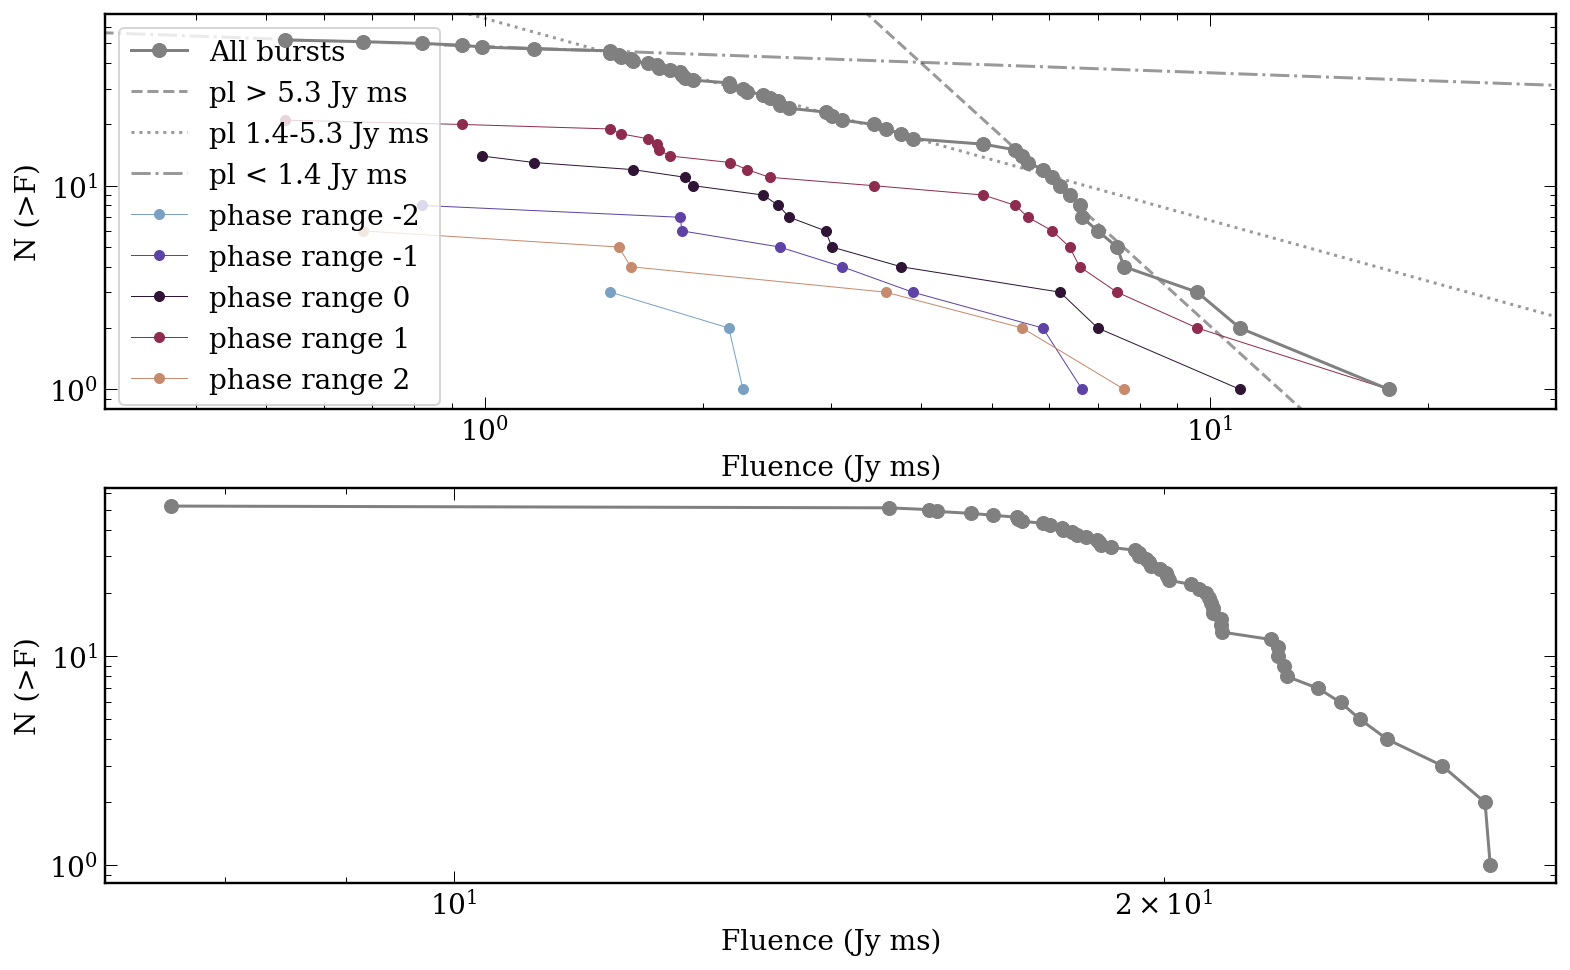

In [25]:
cm = plt.cm.get_cmap('twilight')
fig = plt.figure()
gs = gridspec.GridSpec(2,1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(arts_fluence, cumulative_n, zorder=10, linestyle='-', marker='o', color='gray',
            label="All bursts")
ax1.set_xlabel('Fluence (Jy ms)')
ax1.set_ylabel('N (>F)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(3e-1,30)
ax1.set_ylim(8e-1,70)

fl_hi, fl_md, fl_lo = [], [], []
cm_hi, cm_md, cm_lo = [], [], []

print(arts_fluence)

for j,f in enumerate(arts_fluence):
    if f < 1.4:
        fl_lo.append(f)
        cm_lo.append(cumulative_n[j])
    elif f > 5.3:
        fl_hi.append(f)
        cm_hi.append(cumulative_n[j])
    else:
        fl_md.append(f)
        cm_md.append(cumulative_n[j])

print(fl_md, cm_md)
        
# Fitting
p0=[-2.3, 100]
coeff_hi, var_hi = curve_fit(func_powerlaw, fl_hi, cm_hi, p0=p0)
print(coeff_hi)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_hi), 
         color='k', alpha=0.4, linestyle='--', label='pl > 5.3 Jy ms')

coeff_md, var_md = curve_fit(func_powerlaw, fl_md, cm_md, p0=p0)
print(coeff_md)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_md), 
         color='k', alpha=0.4, linestyle='dotted', label='pl 1.4-5.3 Jy ms')

coeff_lo, var_lo = curve_fit(func_powerlaw, fl_lo, cm_lo, p0=p0)
print(coeff_lo)
ax1.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_lo), 
         color='k', alpha=0.4, linestyle='-.', label='pl < 1.4 Jy ms')

phase_range = [0.36, 0.44, 0.47, 0.49, 0.52, 0.6]
color_test=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
for i,p in enumerate(phase_range[:-1]):
    c = cm((i+1)/len(phase_range))#color_test[i]
    flist = []
    for j,f in enumerate(arts_fluence):
        if arts_phase[j] > p and arts_phase[j] < phase_range[i+1]:
            flist.append(f)
    #print(flist)
    ax1.plot(flist, [len(flist)-i for i in range(len(flist))], linestyle='-', marker='o', color=c,
            label="phase range "+str(i-2), markersize=5, linewidth=0.5)
ax1.legend()

# PSR CMD
cum_n_psr = np.array([len(psr_fluence)-i for i in range(len(psr_fluence))])

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(psr_fluence, cum_n_psr, linestyle='-', marker='o', color='gray')
ax2.set_xlabel('Fluence (Jy ms)')
ax2.set_ylabel('N (>F)')
ax2.set_xscale('log')
ax2.set_yscale('log')

### SNR CDF

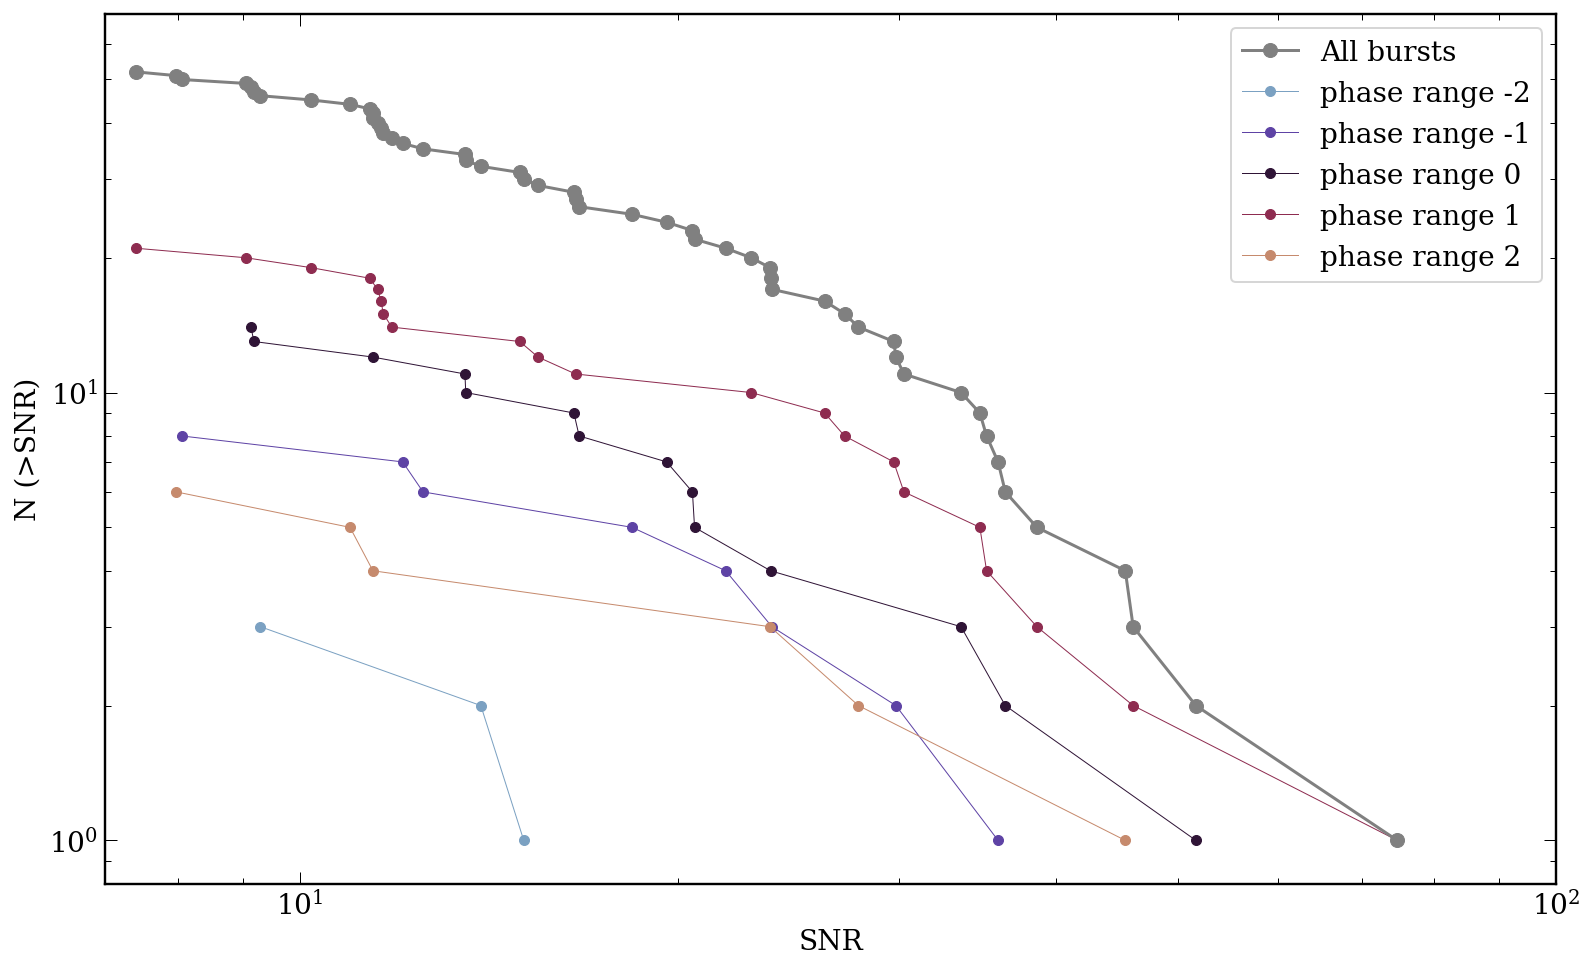

In [26]:
cm = plt.cm.get_cmap('twilight')
arts_snr.sort()
plt.plot(arts_snr, cumulative_n, zorder=10, linestyle='-', marker='o', color='gray',
            label="All bursts")
plt.xlabel('SNR')
plt.ylabel('N (>SNR)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(7,100)
plt.ylim(8e-1,70)

# snr_hi, snr_md, snr_lo = [], [], []
# cm_hi, cm_md, cm_lo = [], [], []

# for j,snr in enumerate(arts_snr):
#     if f < 1.4:
#         snr_lo.append(snr)
#         cm_lo.append(cumulative_n[j])
#     elif f > 5.3:
#         snr_hi.append(snr)
#         cm_hi.append(cumulative_n[j])
#     else:
#         snr_md.append(snr)
#         cm_md.append(cumulative_n[j])

# print(fl_md)


# # Fitting
# p0=[-2.3, 100]
# coeff_hi, var_hi = curve_fit(func_powerlaw, snr_hi, cm_hi, p0=p0)
# print(coeff_hi)
# plt.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_hi), 
#          color='k', alpha=0.4, linestyle='--', label='pl > 5.3 Jy ms')

# coeff_md, var_md = curve_fit(func_powerlaw, snr_md, cm_md, p0=p0)
# print(coeff_md)
# plt.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_md), 
#          color='k', alpha=0.4, linestyle='dotted', label='pl 1.4-5.3 Jy ms')

# coeff_lo, var_lo = curve_fit(func_powerlaw, snr_lo, cm_lo, p0=p0)
# print(coeff_lo)
# plt.plot(np.logspace(-1,2), func_powerlaw(np.logspace(-1,2), *coeff_lo), 
#          color='k', alpha=0.4, linestyle='-.', label='pl < 1.4 Jy ms')

phase_range = [0.36, 0.44, 0.47, 0.49, 0.52, 0.6]
color_test=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
for i,p in enumerate(phase_range[:-1]):
    c = cm((i+1)/len(phase_range))#color_test[i]
    snrlist = []
    for j,f in enumerate(arts_snr):
        if arts_phase[j] > p and arts_phase[j] < phase_range[i+1]:
            snrlist.append(f)
    #print(flist)
    plt.plot(snrlist, [len(snrlist)-i for i in range(len(snrlist))], linestyle='-', marker='o', color=c,
            label="phase range "+str(i-2), markersize=5, linewidth=0.5)
plt.legend()

### Energy CDF

In [49]:
cm = plt.cm.get_cmap('twilight')
arts_energy.sort()
energy = arts_energy.value
plt.plot(energy, cumulative_n, zorder=10, linestyle='-', marker='o', color='gray',
            label="All bursts")
plt.xlabel('Energy (erg)')
plt.ylabel('N (>E)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(3e36,2e38)
plt.ylim(8e-1,70)

e_hi, e_md, e_lo = [], [], []
cm_hi, cm_md, cm_lo = [], [], []

for j,f in enumerate(energy):
    if f < 1e37 :
        e_lo.append(f)
        cm_lo.append(cumulative_n[j])
    elif f > 4e37:
        e_hi.append(f)
        cm_hi.append(cumulative_n[j])
    else:
        e_md.append(f)
        cm_md.append(cumulative_n[j])
#print(e_hi, e_md, e_lo)

# Fitting
p0=[-4, 100]
coeff_hi, var_hi = curve_fit(func_powerlaw, e_hi, cm_hi, p0=p0)
print(coeff_hi)
plt.plot(np.logspace(36,39), func_powerlaw(np.logspace(-1,2), *coeff_hi), 
         color='k', alpha=0.4, linestyle='--', label='pl > 5.3 Jy ms')

coeff_md, var_md = curve_fit(func_powerlaw, e_md, cm_md, p0=p0)
print(coeff_md)
plt.plot(np.logspace(36,39), func_powerlaw(np.logspace(-1,2), *coeff_md), 
         color='k', alpha=0.4, linestyle='dotted', label='pl 1.4-5.3 Jy ms')

coeff_lo, var_lo = curve_fit(func_powerlaw, e_lo, cm_lo, p0=p0)
print(coeff_lo)
plt.plot(np.logspace(36,39), func_powerlaw(np.logspace(-1,2), *coeff_lo), 
         color='k', alpha=0.4, linestyle='-.', label='pl < 1.4 Jy ms')

phase_range = [0.36, 0.44, 0.47, 0.49, 0.52, 0.6]
for i,p in enumerate(phase_range[:-1]):
    c = cm((i+1)/len(phase_range))#color_test[i]
    elist = []
    for j,f in enumerate(energy):
        if arts_phase[j] > p and arts_phase[j] < phase_range[i+1]:
            elist.append(f)
    #print(flist)
    plt.plot(elist, [len(elist)-i for i in range(len(elist))], linestyle='-', marker='o', color=c,
            label="phase range "+str(i-2), markersize=5, linewidth=0.5)
plt.legend()

[ -4. 100.]


/home/ines/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


ValueError: array must not contain infs or NaNs

# Waiting time between bursts

In [50]:
burst_data = pd.read_csv('/home/ines/Documents/projects/R3/arts/struct_opt_dm/arts_r3_properties.csv')
bary_mjd = burst_data['bary_mjd']
dmjd = [(bary_mjd[i+1]-bary_mjd[i])*24*3600 for i in range(len(bary_mjd)-1)]
print(min(dmjd))

FileNotFoundError: File b'/home/ines/Documents/projects/R3/arts/struct_opt_dm/arts_r3_properties.csv' does not exist

[1.00000000e+01 1.22954263e+01 1.51177507e+01 1.85879189e+01
 2.28546386e+01 2.81007524e+01 3.45510729e+01 4.24820170e+01
 5.22334507e+01 6.42232542e+01 7.89652287e+01 9.70911147e+01
 1.19377664e+02 1.46779927e+02 1.80472177e+02 2.21898234e+02
 2.72833338e+02 3.35460219e+02 4.12462638e+02 5.07140396e+02
 6.23550734e+02 7.66682207e+02 9.42668455e+02 1.15905105e+03
 1.42510267e+03 1.75222448e+03 2.15443469e+03 2.64896929e+03
 3.25702066e+03 4.00464573e+03 4.92388263e+03 6.05412358e+03
 7.44380301e+03 9.15247311e+03 1.12533558e+04 1.38364807e+04
 1.70125428e+04 2.09176466e+04 2.57191381e+04 3.16227766e+04]


Text(0.5, 0, 'Wait time (s)')

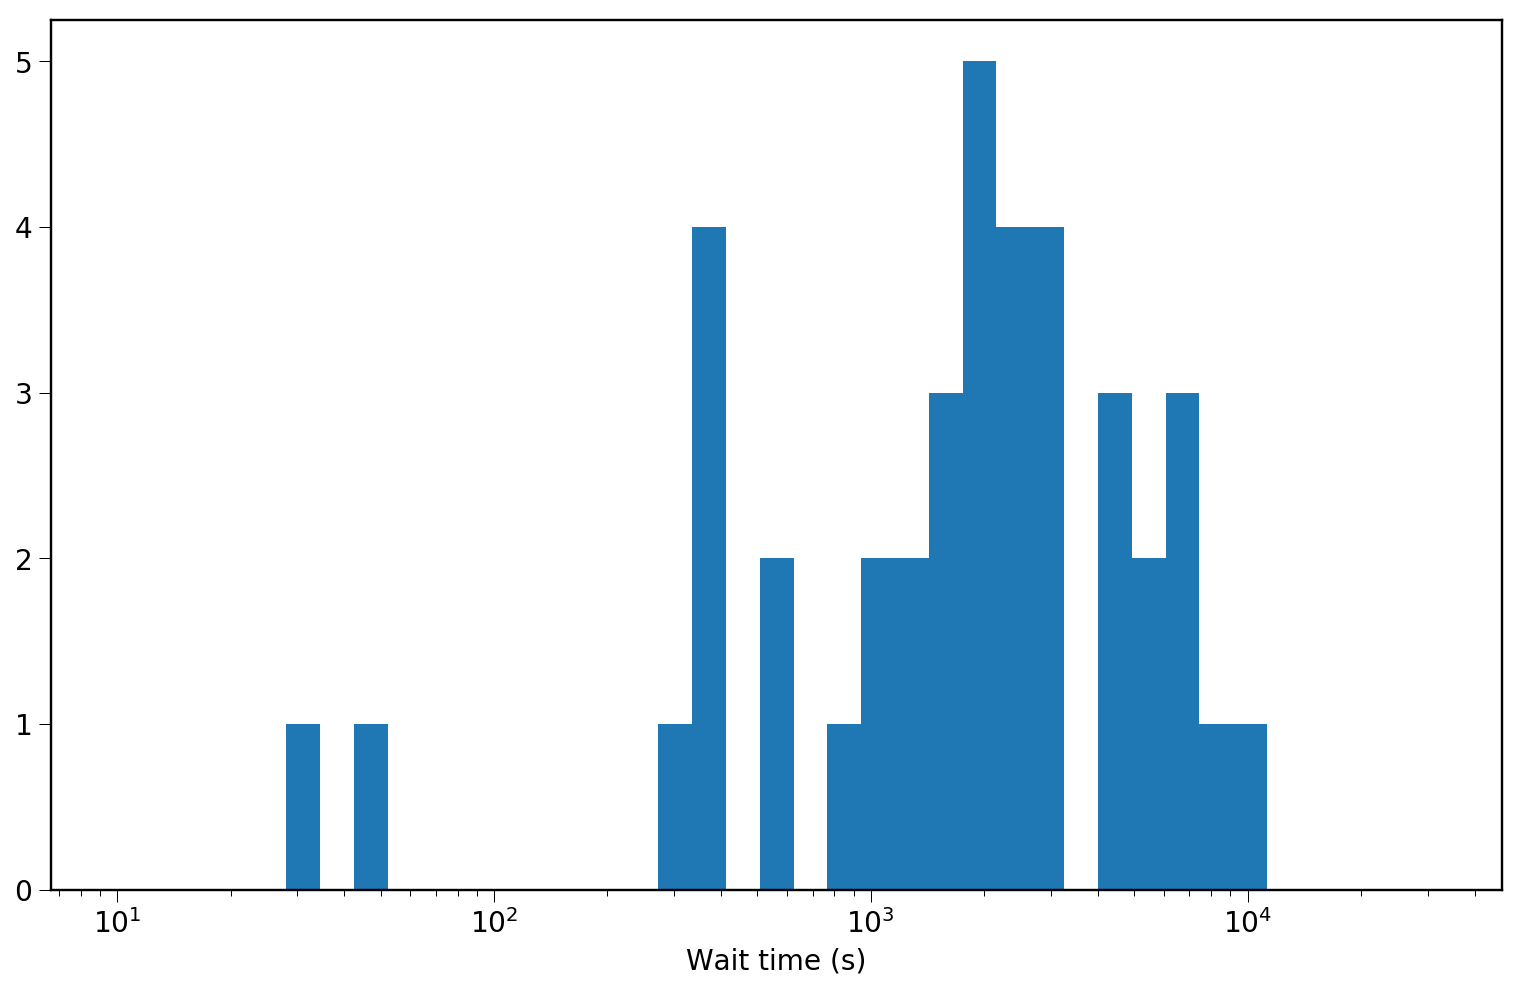

In [103]:
logbins = np.logspace(1,4.5,40)
print(logbins)
#plt.hist(dmjd, bins=logbins, range=(0,0.5))
plt.hist(dmjd, bins=logbins)
plt.xscale('log')
plt.xlabel("Wait time (s)")